## 1. Data Upload

In [1]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

path_csv = '.'

# Read the CSV files into pandas dataframes
input_formal_model = pd.read_csv(f"{path_csv}/formal_model.csv")

In [2]:
input_formal_model

,Formal Model,f1,f2,f3,f4,f5
0,1,2.8,-1.8,-2.800000,1.300000,0.4
1,2,2.9,-1.9,-2.900000,1.400000,0.5
2,3,3.0,-2.0,-3.000000,1.500000,0.6
3,4,3.1,-2.1,-3.100000,1.600000,0.7
4,5,3.2,-2.2,-3.200000,1.700000,0.8
5,6,-1.6,-2.5,1.500000,0.200000,0.6
6,7,-1.3,-2.7,1.300000,0.400000,0.8
7,8,-1.0,-3.0,1.500000,0.600000,1.0
8,9,-0.7,-3.2,1.700000,0.800000,1.2
9,10,-0.5,-3.5,1.900000,1.000000,1.4


## 2. Multi-dimensional scaling

In [3]:
# Drop the 'Formal Model' column as it's an identifier and not part of the features
formal_model_values = input_formal_model.drop('Formal Model', axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(formal_model_values)

# Apply MDS to reduce the dimensions to 2
mds = MDS(n_components=2, normalized_stress='auto')
X_mds = mds.fit_transform(X_scaled)

# Convert the reduced data back to a pandas DataFrame
formal_model_reduced = pd.DataFrame(X_mds, columns=["x1", "x2"])

print(formal_model_reduced)


          x1        x2
0  -1.425186 -1.395002
1  -1.412053 -1.585589
2  -1.397809 -1.777545
3  -1.380033 -1.971417
4  -1.360750 -2.166395
5   1.962868  0.412341
6   1.902230  0.019814
7   2.014341 -0.402321
8   2.086405 -0.768623
9   2.258178 -1.185975
10 -0.652162  1.853950
11 -0.650792  2.038087
12 -0.646662  2.181090
13 -0.652857  2.298913
14 -0.645720  2.448672


In [4]:
formal_model_values

,f1,f2,f3,f4,f5
0,2.8,-1.8,-2.800000,1.300000,0.4
1,2.9,-1.9,-2.900000,1.400000,0.5
2,3.0,-2.0,-3.000000,1.500000,0.6
3,3.1,-2.1,-3.100000,1.600000,0.7
4,3.2,-2.2,-3.200000,1.700000,0.8
5,-1.6,-2.5,1.500000,0.200000,0.6
6,-1.3,-2.7,1.300000,0.400000,0.8
7,-1.0,-3.0,1.500000,0.600000,1.0
8,-0.7,-3.2,1.700000,0.800000,1.2
9,-0.5,-3.5,1.900000,1.000000,1.4


## 3. Visual analytics

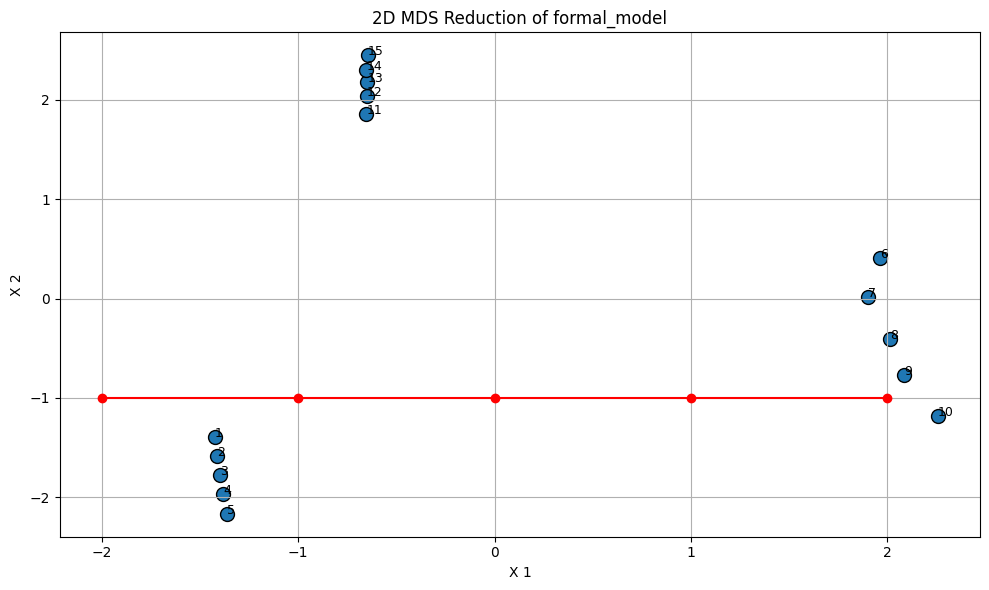

In [5]:
import matplotlib.pyplot as plt

# Scatter plot for the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(formal_model_reduced['x1'], formal_model_reduced['x2'], s=100, edgecolor='k')
for i, txt in enumerate(input_formal_model['Formal Model']):
    plt.annotate(txt, (formal_model_reduced['x1'].iloc[i], formal_model_reduced['x2'].iloc[i]), fontsize=9)

# Draw the separating line
# You might need to adjust these values based on your visualization
line_x1 = [-2, -1, 0, 1, 2]  # Example x-values for 5 points
line_x2 = [-1, -1, -1, -1, -1]  # Corresponding y-values, adjust to separate the classes
plt.plot(line_x1, line_x2, 'ro-')

plt.xlabel("X 1")
plt.ylabel("X 2")
plt.title("2D MDS Reduction of formal_model")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
def interpolate_coordinates(x_1, x_n, n):
    """
    :param x_1: 
    :param x_n: 
    :param n: 
    :return: 
    """
    # Ensure n is greater than 1 to avoid division by zero
    if n <= 1:
        raise ValueError("n must be greater than 1 to calculate intermediate points.")

    # List to hold all the coordinates including the first and the last
    inter_coordinates = []

    # Calculate each intermediate coordinate
    for i in range(0, n):
        x_i = x_1 + ((x_n - x_1) * i) / (n - 1)
        inter_coordinates.append(x_i)

    return inter_coordinates


In [7]:
x_1_first = 2
x_1_last = -4
x_2_first = -4
x_2_last = 1
num_points = 5

x_1_inter_coordinates = interpolate_coordinates(x_1_first, x_1_last, num_points)
x_2_inter_coordinates = interpolate_coordinates(x_2_first, x_2_last, num_points)
# print(x_1_inter_coordinates)
# print(x_2_inter_coordinates)

# Create a DataFrame from the coordinates
coordinates_df = pd.DataFrame({'x1': x_1_inter_coordinates, 'x2': x_2_inter_coordinates})
coordinates_df

,x1,x2
0,2.0,-4.00
1,0.5,-2.75
2,-1.0,-1.50
3,-2.5,-0.25
4,-4.0,1.00


## 4. Calculate Transition Matrix

In [8]:
formal_model_reduced_test = [
    (-1.827506713, -2.57210291),
    (-1.805637206, -2.789008261),
    (-1.812439839, -2.99995456),
    (-2.035782748, -2.999989808),
    (-2.225907357, -2.999830184),
    (2.151465808, 2.349428929),
    (2.146415535, 1.848879366),
    (2.335563856, 1.572769993),
    (2.512780867, 1.350090422),
    (2.808853361, 1.168351448),
    (-2.397040617, 2.674381769),
    (-2.415455455, 2.889854745),
    (-2.508854802, 2.999784436),
    (-2.621571267, 2.999927152),
    (-2.71963759, 2.998711285)
]

formal_model_reduced_test = pd.DataFrame(formal_model_reduced_test)

### 3.1. Singular Value Decomposition (SVD)

In [9]:
# Receive values from the matrix A DataFrame 
formal_model_reduced_values = formal_model_reduced_test.values

# Calculate SVD
U, s, Vt = np.linalg.svd(formal_model_reduced_values)

# Construct the full diagonal matrix
S = np.zeros(formal_model_reduced_values.shape)
for i in range(min(formal_model_reduced_values.shape)):
    S[i, i] = s[i]

# print("U:\n", U)
# print("\nS:\n", S)
# print("\nVt:\n", Vt)


### 3.2. Create the reconstructed matrix of SVD

In [10]:
# Recompute the original matrix using U, S, and Vt
reconstructed_matrix = U.dot(S.dot(Vt))

# Convert the reconstructed matrix to a pandas DataFrame, if desired
reconstructed_df = pd.DataFrame(reconstructed_matrix)


In [11]:
reconstructed_df

,0,1
0,-1.827507,-2.572103
1,-1.805637,-2.789008
2,-1.812440,-2.999955
3,-2.035783,-2.999990
4,-2.225907,-2.999830
5,2.151466,2.349429
6,2.146416,1.848879
7,2.335564,1.572770
8,2.512781,1.350090
9,2.808853,1.168351


### 3.3. Calculate the generalized inverse of input matrix

In [12]:
# Calculate the generalized (Moore-Penrose) inverse
formal_model_reduced_test_pinv = np.linalg.pinv(formal_model_reduced_test.values)

# Convert to a pandas DataFrame
formal_model_reduced_test_pinv_df = pd.DataFrame(formal_model_reduced_test_pinv)

In [13]:
formal_model_reduced_test_pinv_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.019716,-0.019149,-0.018953,-0.021783,-0.024192,0.024118,0.024724,0.027489,0.030032,0.034027,-0.033946,-0.034468,-0.035798,-0.037226,-0.038467
1,-0.024036,-0.026298,-0.028461,-0.028162,-0.027907,0.021310,0.016164,0.013069,0.010539,0.008273,0.030737,0.032980,0.034236,0.034388,0.034507


### 3.4. Calculate transition matrix T

In [14]:
transition_matrix_T = formal_model_reduced_test_pinv_df.dot(formal_model_values)

In [15]:
transition_matrix_T

,f1,f2,f3,f4,f5
0,-0.627518,-0.037243,0.389966,0.008278,0.622879
1,-0.319291,-0.094071,0.648864,-0.238340,-0.520302


## 4. Create Hyperplane

In [16]:
coordinates_hyperplane_df = coordinates_df.values @ transition_matrix_T.values

In [17]:
coordinates_hyperplane_df

array([[ 0.02212588,  0.30179639, -1.81552575,  0.96991542,  3.32696479],
       [ 0.56429012,  0.24007288, -1.5893939 ,  0.65957372,  1.7422696 ],
       [ 1.10645436,  0.17834937, -1.36326204,  0.34923201,  0.1575744 ],
       [ 1.6486186 ,  0.11662585, -1.13713018,  0.0388903 , -1.42712079],
       [ 2.19078283,  0.05490234, -0.91099833, -0.27145141, -3.01181599]])

In [18]:
# Adding a new column with all values set to 1
new_column = np.ones((coordinates_hyperplane_df.shape[0], 1))
feature_vector_inverse = np.hstack((new_column, coordinates_hyperplane_df))

feature_vector_inverse

array([[ 1.        ,  0.02212588,  0.30179639, -1.81552575,  0.96991542,
         3.32696479],
       [ 1.        ,  0.56429012,  0.24007288, -1.5893939 ,  0.65957372,
         1.7422696 ],
       [ 1.        ,  1.10645436,  0.17834937, -1.36326204,  0.34923201,
         0.1575744 ],
       [ 1.        ,  1.6486186 ,  0.11662585, -1.13713018,  0.0388903 ,
        -1.42712079],
       [ 1.        ,  2.19078283,  0.05490234, -0.91099833, -0.27145141,
        -3.01181599]])

In [19]:
# Feature vector X
# feature_vector_inverse = np.array([
#     [1, 0.022126, 0.301796, -1.815526, 0.969915, 3.326965],
#     [1, 0.564290, 0.240073, -1.589394, 0.659574, 1.742270],
#     [1, 1.106454, 0.178349, -1.363262, 0.349232, 0.157574],
#     [1, 1.648619, 0.116626, -1.137130, 0.038890, -1.427121],
#     [1, 2.190783, 0.054902, -0.910998, -0.271451, -3.011816]
# ])

# Optimization criteria function
def optimization_criteria(W, X):
    return np.sum(np.abs(X.dot(W.T)))

# Initial guess (starting point for the optimization algorithm)
weights_inverse_initial = np.zeros(feature_vector_inverse.shape[1])

# Bounds for W (setting it between -1 and 1)
bounds = [(-1, 1) for _ in range(feature_vector_inverse.shape[1])]

# The actual optimization
res = minimize(
    optimization_criteria,
    weights_inverse_initial,
    args=(feature_vector_inverse,),
    method='SLSQP',
    bounds=bounds,
    options={'disp': True}
)

# Checking if the optimization was successful
if res.success:
    # Extract the weights into a DataFrame
    weights_inverse_output = pd.DataFrame(res.x, index=[f'w{i}' for i in range(len(res.x))], columns=['weight'])

    print("Optimization was successful. The weights are:")
    print(weights_inverse_output)

    # Output the value of the optimization criteria
    print("\nValue of the optimization criteria (objective function value):", res.fun)
else:
    print("Optimization failed.")

# Checking for convergence
print("\nConvergence status:", res.message)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2145308795705042e-06
            Iterations: 9
            Function evaluations: 98
            Gradient evaluations: 9
Optimization was successful. The weights are:
      weight
w0  0.000123
w1 -0.000300
w2  0.000060
w3 -0.000109
w4  0.000215
w5 -0.000163

Value of the optimization criteria (objective function value): 2.2145308795705042e-06

Convergence status: Optimization terminated successfully


In [20]:
weights_inverse_output

,weight
w0,0.000123
w1,-0.000300
w2,0.000060
w3,-0.000109
w4,0.000215
w5,-0.000163


In [28]:
# Assuming the row with 'w0' is the first row as per your example
# we want to move this row to the end of the DataFrame
weights_df_reordered = pd.concat([weights_inverse_output.iloc[1:], weights_inverse_output.iloc[0:1]]).reset_index(drop=True)

# Show the modified DataFrame
weights_df_reordered


,weight
0,-0.000300
1,0.000060
2,-0.000109
3,0.000215
4,-0.000163
5,0.000123


In [30]:
# DataFrames as provided
test_weights_df = pd.DataFrame({
    'weights': [-0.000300, 0.000060, -0.000109, 0.000215, -0.000163, 0.000123]
})

test_features_df = pd.DataFrame({
    'x1': [2.8, 2.9, 3.0, 3.1, 3.2, -1.6, -1.3, -1.0, -0.7, -0.5, 1.2, 1.1, 1.0, 0.9, 0.8],
    'x2': [-1.8, -1.9, -2.0, -2.1, -2.2, -2.5, -2.7, -3.0, -3.2, -3.5, -1.2, -1.1, -1.0, -0.9, -0.8],
    'x3': [-2.8, -2.9, -3.0, -3.1, -3.2, 1.5, 1.3, 1.5, 1.7, 1.9, 0.7, 0.8, 0.844444, 0.85, 0.9],
    'x4': [1.3, 1.4, 1.5, 1.6, 1.7, 0.2, 0.4, 0.6, 0.8, 1.0, -0.3, -0.4, -0.444444, -0.45, -0.5],
    'x5': [0.4, 0.5, 0.6, 0.7, 0.8, 0.6, 0.8, 1.0, 1.2, 1.4, -2.8, -2.9, -3.0, -3.1, -3.2],
    'x0': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Assuming a bias term with all ones
})

# Multiply the features by the weights
result = test_features_df.mul(test_weights_df['weights'].values, axis=1)

# Sum along the rows to get the final single column for predictions
predictions = result.sum(axis=1)

# Convert the series to a data frame
predictions_df = predictions.to_frame(name='prediction')

# Display the result
print(predictions_df)


    prediction
0    -0.000305
1    -0.000325
2    -0.000345
3    -0.000365
4    -0.000385
5     0.000235
6     0.000165
7     0.000045
8    -0.000068
9    -0.000157
10    0.000007
11    0.000027
12    0.000064
13    0.000115
14    0.000151


In [31]:
test_weights_df

,weights
0,-0.000300
1,0.000060
2,-0.000109
3,0.000215
4,-0.000163
5,0.000123


In [32]:
weights_df_reordered

,weight
0,-0.000300
1,0.000060
2,-0.000109
3,0.000215
4,-0.000163
5,0.000123


In [33]:
# Create a new DataFrame with an additional column
new_formal_model_values = formal_model_values.copy()
new_formal_model_values['f0'] = 1
new_formal_model_values


,f1,f2,f3,f4,f5,f0
0,2.8,-1.8,-2.800000,1.300000,0.4,1
1,2.9,-1.9,-2.900000,1.400000,0.5,1
2,3.0,-2.0,-3.000000,1.500000,0.6,1
3,3.1,-2.1,-3.100000,1.600000,0.7,1
4,3.2,-2.2,-3.200000,1.700000,0.8,1
5,-1.6,-2.5,1.500000,0.200000,0.6,1
6,-1.3,-2.7,1.300000,0.400000,0.8,1
7,-1.0,-3.0,1.500000,0.600000,1.0,1
8,-0.7,-3.2,1.700000,0.800000,1.2,1
9,-0.5,-3.5,1.900000,1.000000,1.4,1


In [34]:
# # Multiply the features by the weights
my_result = new_formal_model_values.mul(weights_df_reordered['weight'].values, axis=1)

# Sum along the rows to get the final single column for predictions
my_predictions = my_result.sum(axis=1)

# Convert the series to a data frame
my_predictions_df = my_predictions.to_frame(name='prediction')

In [42]:
my_differ_df = pd.DataFrame({'Column1': my_predictions_df, 'Column2': predictions_df})

ValueError: If using all scalar values, you must pass an index

In [ ]:
my_differ_df

In [36]:
my_diff = predictions_df - my_predictions_df

In [37]:
print(my_diff)

      prediction
0  -1.191026e-06
1  -1.239575e-06
2  -1.288124e-06
3  -1.336673e-06
4  -1.385222e-06
5  -6.305347e-07
6  -7.155629e-07
7  -6.970744e-07
8  -6.507944e-07
9  -6.443756e-07
10  8.597879e-08
11  1.345278e-07
12  1.703452e-07
13  1.968619e-07
14  2.338230e-07
